# 캐글 IEEE Computational Intelligence Society
- https://www.kaggle.com/c/ieee-fraud-detection/overview
- 카드 기록을 활용한 사기 거래 탐지
- 대부분 컬럼이 비식별화 되어 있어, 데이터 탐색을 통한 데이터에 대한 이해가 매우 중요하다.

# 사용 데이터

#### train.csv: 모델 학습용 데이터(데이터가 커서 샘플링된 데이터 제공) / test.csv: 모델 평가용 데이터
- TransactionID: 거래 ID ( 비식별화 )
- TransactionDT: 거래 시각 ( 비식별화 )
- TransactionAmt: 거래 금액(US Dollar)
- ProductCD: 상품 코드
- card1 – card6: 카드 관련 정보(비식별화)
- P_emaildomain, R_emaildomain: 이메일 정보
- M1 – M9: 기존 거래와의 매칭 정보
- isFraud : 사기 거래 여부

#### 전체적으로 비식별화된 컬럼이 많고 결측치가 많으며 클래스 불균형 문제가 존재한다.


## 1. 데이터 불러오기 및 기본 설정

In [1]:
import os
import pandas as pd
import numpy as np
# os.chdir(r"C:\Users\GilseungAhn\Google 드라이브\작업\온라인 강의 머신러닝 성능 향상을 위한 데이터 탐색과 전처리 심화\데이터\실습 데이터 - #6\IEEE-CIS Fraud Detection")

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (20, 5)

import warnings
warnings.filterwarnings("ignore")

#### 1.1 데이터 불러오기 및 불필요한 변수 삭제

In [2]:
df = pd.read_csv("sampled_train_transaction.csv")

In [3]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,1.0,T,T,T,M2,F,T,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,1.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,1.0,T,T,T,M0,F,F,F,F,F
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,1.0,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.drop(['TransactionID', 'TransactionDT'], axis = 1, inplace = True) # 도메인 지식하에, 불필요한 변수라 판단하여 삭제

#### 1.2 데이터 분리

- df: sampled_train_transaction.csv
- 'TransactionID', 'TransactionDT’ 변수는 삭제
- X: df에서 isFraud가 제거된 데이터 프레임
- Y: df에서 isFraud값만 가져온 Series
- Train_X, Test_X, Train_Y, Test_Y


In [5]:
X = df.drop(['isFraud'], axis = 1)
Y = df['isFraud']

from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)

## 2. 변수 탐색

#### 2.1 라벨 확인
- 사기 거래가 아닌 거래가 전체 거래의 97.4%를 차지
- 클래스 불균형 문제가 발생할 확률이 매우 높아보임

- Train_Y에 대해, value_counts 를 적용하여 라벨 분포 확인
- 클래스 불균형 문제가 발생할 확률이 매우 높아 보임

In [6]:
Train_Y.value_counts(normalize = True)

0    0.974187
1    0.025813
Name: isFraud, dtype: float64

In [7]:
Train_Y.value_counts(normalize = False)

0    73064
1     1936
Name: isFraud, dtype: int64

#### 2.2 변수별 상태 공간 확인: 컬럼별 유니크한 값 일부 확인
- Train_X에 포함된 모든 컬럼에 대해, 타입, 결측개수, 상태공간 크기, 상태 공간 일부를 확인
- 이를 바탕으로 결측이 포함된 변수와 그렇지 않은 변수, 연속형 변수와 범주형 변수를 구분


#### 탐색 내용
- TransactionAmt는 연속형 변수임이 확실해보임 (히스토그램 등으로 확인)
- ProductCD, card4, card6은 범주형 변수임이 확실해보임 (결측 포함)
- P_emaildomain, R_emaildomain은 구매자의 이메일 도메인으로 보임. 직관적으로 봤을 때, 유의한 의미가 있을지 의심되며, 둘은 관계가 있을 것으로 보임
- card1, card2, card3, card5은 연속형 변수임이 확실해보임 (히스토그램 등으로 확인)
- 많은 변수에서 결측이 포함되어 있음
- C3를 제외한 C1 ~ C14는 모두 연속형 변수인 것으로 보임. 비식별화되어 있어 대략적인 의미라도 추측을 해야 함
- 결측이 매우 많아, 곧바로 대체하기에는 부담이 있어, 결측 분포 확인 필요
- M1 ~ M9는 매칭 정보이며, 전부 범주형 변수임이 확실함. T는 매칭됨, F는 매칭되지 않음을 나타내는 것으로 보이며, 모두 결측이 포함

In [8]:
for col in Train_X.columns:
    print("변수: {}, 타입: {}, 결측 개수: {}, 상태공간 크기: {}, 상태공간 일부: {}".format(col, Train_X[col].dtype, Train_X[col].isnull().sum(), len(Train_X[col].unique()), Train_X[col].unique()[:5]))

변수: TransactionAmt, 타입: float64, 결측 개수: 0, 상태공간 크기: 5471, 상태공간 일부: [190.    32.97 117.   125.   100.  ]
변수: ProductCD, 타입: object, 결측 개수: 0, 상태공간 크기: 5, 상태공간 일부: ['W' 'R' 'H' 'C' 'S']
변수: card1, 타입: int64, 결측 개수: 0, 상태공간 크기: 6895, 상태공간 일부: [ 9500 10057  7207  2772 13220]
변수: card2, 타입: float64, 결측 개수: 1035, 상태공간 크기: 497, 상태공간 일부: [321. 225. 111. 512. 562.]
변수: card3, 타입: float64, 결측 개수: 2, 상태공간 크기: 71, 상태공간 일부: [150. 185. 131. 213. 144.]
변수: card4, 타입: object, 결측 개수: 6, 상태공간 크기: 5, 상태공간 일부: ['visa' 'mastercard' 'american express' 'discover' nan]
변수: card5, 타입: float64, 결측 개수: 380, 상태공간 크기: 84, 상태공간 일부: [226. 224. 197. 166. 119.]
변수: card6, 타입: object, 결측 개수: 3, 상태공간 크기: 5, 상태공간 일부: ['debit' 'credit' nan 'debit or credit' 'charge card']
변수: P_emaildomain, 타입: object, 결측 개수: 11544, 상태공간 크기: 60, 상태공간 일부: ['gmail.com' 'yahoo.com' 'verizon.net' 'hotmail.com' nan]
변수: R_emaildomain, 타입: object, 결측 개수: 49131, 상태공간 크기: 61, 상태공간 일부: [nan 'gmail.com' 'hotmail.com' 'yahoo.com' 'anonymous.com']
변수

#### 2.3 탐색을 위한 데이터 준비: 특징과 라벨 데이터 병합

- Train_X와 Train_Y를 열 기준으로 병합하여 탐색을 위한 데이터를 준비 : Train_df
- 이는 특징에 따른 라벨의 분포를 확인하기 위한 선행 작업임


In [9]:
Train_df = pd.concat([Train_X, Train_Y], axis = 1)
Train_df.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,P_emaildomain,R_emaildomain,...,M1,M2,M3,M4,M5,M6,M7,M8,M9,isFraud
3829,190.00,W,9500,321.0,150.0,visa,226.0,debit,gmail.com,NaN,...,NaN,NaN,NaN,M0,F,T,NaN,NaN,NaN,0
21977,32.97,W,10057,225.0,150.0,mastercard,224.0,debit,yahoo.com,NaN,...,T,T,T,NaN,NaN,F,NaN,NaN,NaN,0
88588,117.00,W,7207,111.0,150.0,visa,226.0,debit,verizon.net,NaN,...,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,0
69489,125.00,R,2772,512.0,150.0,visa,226.0,debit,gmail.com,gmail.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
65218,100.00,H,13220,562.0,150.0,mastercard,197.0,credit,gmail.com,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


#### 2.4 범주형 변수 탐색
##### 탐색 방법
1. 결측을 문자로 변환 (탐색을 위해 임시 변환) <br>
2. 변수별 분포 확인 (bar plot) <br>
3. 변수와 특징 간 관계 확인 (groupby)

##### 탐색 결과 활용
1. 주요 값 기준 이진화
2. 더미화

2.4.1 ProductCD

In [10]:
Train_df['ProductCD'].isnull().sum() # 결측이 전혀없어서, 결측을 문자로 변환할 필요 없음

0

<AxesSubplot:>

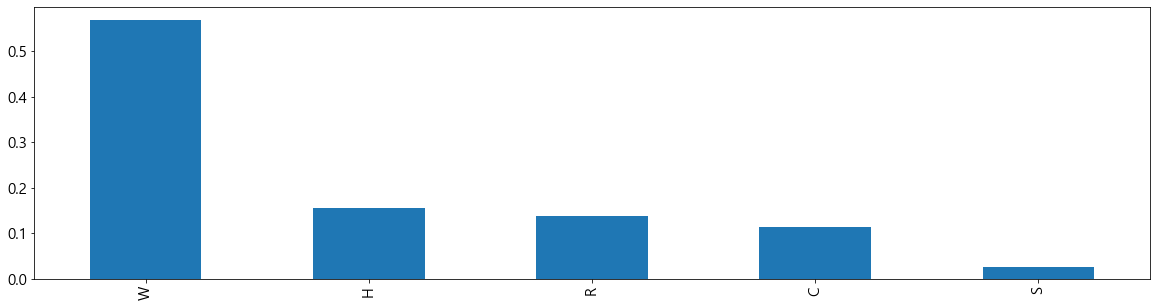

In [11]:
Train_df['ProductCD'].value_counts(normalize = True).plot(kind = 'bar') # value_counts에 대한 bar plot 생성
# ProdudctCD가 W가 매우 높은 비율을 차지하며, S는 1% 가량됨을 확인

In [12]:
# 상품별로 차이가 존재함을 확인 (다만, H와 W는 거의 유사하다고 판단됨)
# 상태 공간의 크기가 그리 크지 않으니, 굳이 변수 값의 군집화는 수행하지 않고 더미화를 하기로 결정
Train_df.groupby('ProductCD')['isFraud'].mean()

ProductCD
C    0.088614
H    0.020413
R    0.010193
S    0.025290
W    0.018609
Name: isFraud, dtype: float64

2.4.2 card4

In [13]:
Train_df['card4'].isnull().sum() # 결측이 6개밖에 되지 않음 ==> 전부 최빈값으로 대체

6

<AxesSubplot:>

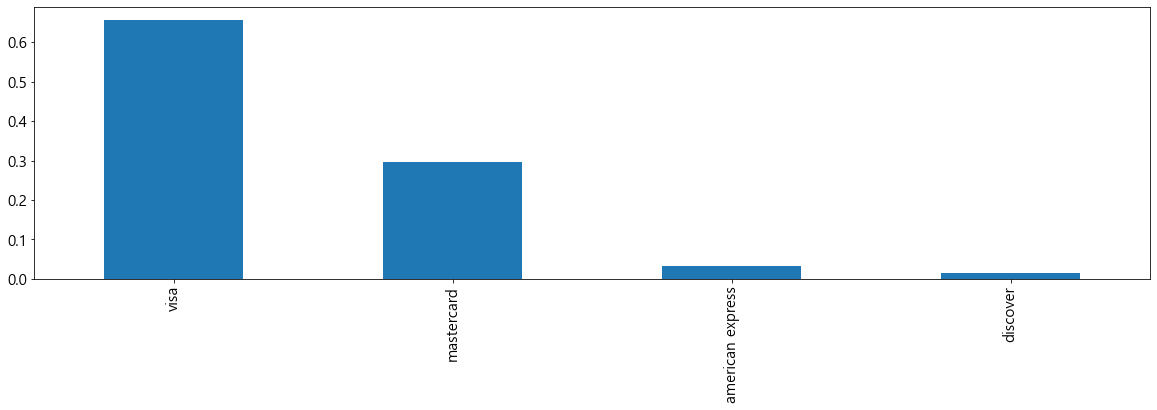

In [14]:
Train_df['card4'].value_counts(normalize = True).plot(kind = 'bar') # value_counts에 대한 bar plot 생성
# visa와 master card가 매우 높은 비율을 차지하며, discover는 거의 발생하지 않음

In [15]:
# 거래의 대다수를 차지하는 visa와 mastercard의 값이 유사
# american express만 유독 값이 작으며 해당 값의 빈도가 높지 않음 => 해당 변수를 american express란 변수로 이진화
# 따라서 결측을 특별히 제거할 필요가 없음
Train_df.groupby('card4')['isFraud'].mean()

card4
american express    0.011138
discover            0.029596
mastercard          0.028823
visa                0.025104
Name: isFraud, dtype: float64

2.4.3 card6

In [16]:
Train_df['card6'].isnull().sum() # 결측이 4개밖에 되지 않음 ==> 전부 최빈값으로 대체

3

<AxesSubplot:>

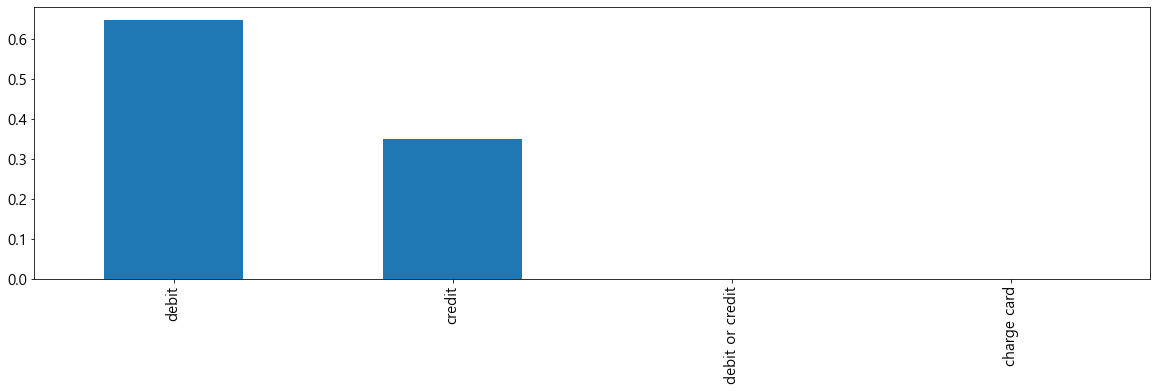

In [17]:
Train_df['card6'].value_counts(normalize = True).plot(kind = 'bar') # value_counts에 대한 bar plot 생성
# debit과 credit이 대다수를 차지. 다른 값들은 육안으로 확인이 불가능한 수준

In [18]:
Train_df['card6'].value_counts(normalize = False) # debit or credit, charge card는 빈도가 매우 적음

debit              48635
credit             26354
debit or credit        5
charge card            3
Name: card6, dtype: int64

In [19]:
# credit과 debit의 차이가 존재
# charge card, debit or credit은 전부 0임을 확인 ==> 그러나 빈도 자체가 매우 적어서 그런 것이라 예상됨
# 따라서 credit인지 나타내는 변수로만 변환
Train_df.groupby('card6')['isFraud'].mean()

card6
charge card        0.000000
credit             0.036048
debit              0.020253
debit or credit    0.000000
Name: isFraud, dtype: float64

2.4.4 P_emaildomain과 R_emaildomain

- 이전 탐색에서 각각의 상태 공간 크기가 60, 61임을 확인 (대다수가 gmail 혹은 yahoo 메일임)
- 또한, 결측이 매우 많았는데, email이 결측이라는 것이 어떤 의미가 있을것이라 의심됨
- 샘플의 개수를 고려하더라도 그 크기가 큰 범주형 변수라고 판단 가능
- 두 변수간 관계가 있으리라 쉽게 판단 가능
- 또한, .를 기준으로 앞쪽에는 실제 도메인이, 뒤쪽에는 com, net 등이 포함되어 있어 분할 필요

In [20]:
Train_df['P_emaildomain'].value_counts()

gmail.com           27248
yahoo.com           11929
anonymous.com        6518
hotmail.com          6035
aol.com              3631
comcast.net          1385
icloud.com            667
msn.com               614
outlook.com           587
att.net               524
sbcglobal.net         494
verizon.net           490
live.com              376
bellsouth.net         345
cox.net               295
me.com                278
ymail.com             275
yahoo.com.mx          218
charter.net           172
optonline.net         153
live.com.mx            98
mac.com                89
rocketmail.com         81
earthlink.net          70
mail.com               55
roadrunner.com         54
juno.com               54
embarqmail.com         51
outlook.es             49
gmail                  47
windstream.net         41
twc.com                40
frontier.com           36
q.com                  34
hotmail.es             32
frontiernet.net        31
cfl.rr.com             31
netzero.com            29
aim.com     

In [21]:
Train_df['R_emaildomain'].value_counts()

gmail.com           9733
anonymous.com       5232
hotmail.com         4034
yahoo.com           2425
aol.com              969
comcast.net          592
outlook.com          328
msn.com              234
icloud.com           232
yahoo.com.mx         217
verizon.net          197
sbcglobal.net        183
cox.net              173
me.com               148
live.com             145
bellsouth.net        133
att.net              122
live.com.mx           98
ymail.com             63
optonline.net         55
outlook.es            48
mac.com               46
hotmail.es            32
mail.com              29
charter.net           28
web.de                27
prodigy.net.mx        23
earthlink.net         22
hotmail.fr            21
juno.com              21
embarqmail.com        20
frontier.com          20
roadrunner.com        17
windstream.net        17
q.com                 16
yahoo.fr              16
gmx.de                15
rocketmail.com        14
cfl.rr.com            13
gmail                 10


In [22]:
# 결측이 의미가 있는지 확인 (두 변수 모두 결측이 많다는 것은 위에서 확인함)
# 결측을 나타내는 변수 생성
Train_df['NA_P_emaildomain'] = Train_df['P_emaildomain'].isnull().astype(int)
Train_df['NA_R_emaildomain'] = Train_df['R_emaildomain'].isnull().astype(int)

In [23]:
# P_emaildomain은 크게 문제 없어보임
Train_df.groupby('NA_P_emaildomain')['isFraud'].mean()

NA_P_emaildomain
0    0.025971
1    0.024948
Name: isFraud, dtype: float64

In [24]:
# R_emaildomain은 오히려 결측이 발생하지 않았을 때 사기인 경우가 더 많음을 확인 ==> 변수로 활용
Train_df.groupby('NA_R_emaildomain')['isFraud'].mean()

NA_R_emaildomain
0    0.041671
1    0.017464
Name: isFraud, dtype: float64

In [25]:
# 유의한 도메인만 가져와서 추가 탐색 수행
Train_df['P_emaildomain'] = Train_df['P_emaildomain'].str.split('.', expand = True).iloc[:, 0]
Train_df['R_emaildomain'] = Train_df['R_emaildomain'].str.split('.', expand = True).iloc[:, 0]

In [26]:
# P_emaildomain에 따른 isFraud의 평균 차이가 존재함
# 다만, aim.com, cableone.net 등은 그 빈도가 매우 적어서 이 차이가 유의한 것인지 판단이 불가
Train_df.groupby('P_emaildomain')['isFraud'].mean()

P_emaildomain
aim             0.034483
anonymous       0.010739
aol             0.014597
att             0.007634
bellsouth       0.002899
cableone        0.052632
centurylink     0.000000
cfl             0.000000
charter         0.000000
comcast         0.008664
cox             0.003390
earthlink       0.000000
embarqmail      0.000000
frontier        0.000000
frontiernet     0.096774
gmail           0.034695
gmx             0.000000
hotmail         0.045253
icloud          0.032984
juno            0.000000
live            0.021008
mac             0.000000
mail            0.127273
me              0.014388
msn             0.014658
netzero         0.000000
optonline       0.006536
outlook         0.067610
prodigy         0.000000
protonmail      0.125000
ptd             0.000000
q               0.000000
roadrunner      0.000000
rocketmail      0.000000
sbcglobal       0.000000
sc              0.000000
servicios-ta    0.000000
suddenlink      0.000000
twc             0.000000
verizon    

In [27]:
# P_emaildomain에 따른 isFraud의 평균 차이가 존재함
# 다만, 대다수 값이 그 빈도가 매우 적어서 이 차이가 유의한 것인지 판단이 불가
Train_df.groupby('R_emaildomain')['isFraud'].mean()

R_emaildomain
aim             0.142857
anonymous       0.009557
aol             0.010320
att             0.000000
bellsouth       0.000000
cableone        0.000000
centurylink     0.000000
cfl             0.000000
charter         0.000000
comcast         0.015203
cox             0.011561
earthlink       0.000000
embarqmail      0.000000
frontier        0.000000
frontiernet     0.000000
gmail           0.063533
gmx             0.000000
hotmail         0.060303
icloud          0.038793
juno            0.000000
live            0.004082
mac             0.000000
mail            0.068966
me              0.000000
msn             0.004274
netzero         0.000000
optonline       0.000000
outlook         0.101064
prodigy         0.000000
protonmail      0.500000
ptd             0.000000
q               0.000000
roadrunner      0.000000
rocketmail      0.000000
sbcglobal       0.000000
sc              0.000000
scranton        0.000000
servicios-ta    0.000000
suddenlink      0.000000
twc        

In [28]:
# 같은 거래라면 P_emaildomain과 R_emaildomain이 특정 관계가 있지 않을까?
# 파생 변수 추가 및 확인: 실제 라벨의 분포를 고려했을 때, 1%와 5%의 차이는 꽤 큰 것이라 예상됨 ==> 해당 변수 사용
Train_df['same_emaildomain'] = (Train_df['P_emaildomain'] == Train_df['R_emaildomain']).astype(int)
print(Train_df['same_emaildomain'].value_counts())
print('\n')
print(Train_df.groupby('same_emaildomain')['isFraud'].mean())

0    56184
1    18816
Name: same_emaildomain, dtype: int64


same_emaildomain
0    0.017069
1    0.051924
Name: isFraud, dtype: float64


2.4.5 C3

In [29]:
# 결측이 없음을 이전에서 확인
# 변수 타입은 float인데, 상태 공간의 크기가 크지 않음 ==> 일단은 범주형으로 보는 것이 적절할 것 같음

In [30]:
# 0.0 값이 대다수임을 확인
Train_df['C3'].value_counts(normalize = True)

0.0     0.988907
1.0     0.010293
2.0     0.000640
3.0     0.000107
4.0     0.000013
9.0     0.000013
8.0     0.000013
16.0    0.000013
Name: C3, dtype: float64

In [31]:
Train_df['C3'].value_counts(normalize = False)

0.0     74168
1.0       772
2.0        48
3.0         8
4.0         1
9.0         1
8.0         1
16.0        1
Name: C3, dtype: int64

In [32]:
# 2.0 이상의 값은 거의 존재하지 않기 때문에, 우연히 평균이 0이 나왔을 것이란 추측이 가능
# 0.0은 자주 등장했기 때문에, 라벨의 평균과 유사
# 1.0은 빈도가 어느정도 있음에도 불구하고 라벨의 평균과 크게 다름
# (조금은 위험한) 가설 수립: C3값이 1 이상인지 아닌지에 따른 차이가 존재할 것이다! => C3_over_1 변수 생성
Train_df.groupby('C3')['isFraud'].mean()

C3
0.0     0.026089
1.0     0.001295
2.0     0.000000
3.0     0.000000
4.0     0.000000
8.0     0.000000
9.0     0.000000
16.0    0.000000
Name: isFraud, dtype: float64

In [33]:
Train_Y.value_counts(normalize = True)

0    0.974187
1    0.025813
Name: isFraud, dtype: float64

2.4.6 M 관련 변수
- M1 - M9는 결측도 절반가까이를 포함하여, 대체하는 것은 어려을 것으로 예상됨
- 모두 범주형 변수이며, 값의 출현 패턴이 유사하니 동시에 탐색 수행

In [34]:
# 탐색을 위해, 모든 결측값을 우선 대체
M_columns = ['M' + str(i) for i in range(1, 10)]
Train_df[M_columns] = Train_df[M_columns].fillna("결측")

In [35]:
## 변수 분포 확인
# 1. 결측이 매우 많음 => 단순 대체 및 제거 불가
# 2. M4를 제외하고는 T (True), F (False로 정의됨)
for col in M_columns:
    print(Train_df[col].value_counts())
    print('\n')

결측    51417
T     23583
Name: M1, dtype: int64


결측    51417
T     21234
F      2349
Name: M2, dtype: int64


결측    51417
T     18459
F      5124
Name: M3, dtype: int64


결측    43269
M0    19725
M2     7030
M1     4976
Name: M4, dtype: int64


결측    51679
F     12926
T     10395
Name: M5, dtype: int64


결측    34158
F     21973
T     18869
Name: M6, dtype: int64


결측    63026
F     10269
T      1705
Name: M7, dtype: int64


결측    63026
F      7429
T      4545
Name: M8, dtype: int64


결측    63026
T     10254
F      1720
Name: M9, dtype: int64




In [36]:
## 변수 값별 라벨 확인: 값별로 차이가 있으며, 결측 자체로도 의미가 있어보임
# 결측으로 대체 후 더미화 필요
for col in M_columns:
    print(Train_df.groupby(col)['isFraud'].mean())
    print('\n')

M1
T     0.017301
결측    0.029718
Name: isFraud, dtype: float64


M2
F     0.034057
T     0.015447
결측    0.029718
Name: isFraud, dtype: float64


M3
F     0.029274
T     0.013977
결측    0.029718
Name: isFraud, dtype: float64


M4
M0    0.036046
M1    0.021503
M2    0.087055
결측    0.011694
Name: isFraud, dtype: float64


M5
F     0.018645
T     0.043098
결측    0.024130
Name: isFraud, dtype: float64


M6
F     0.024166
T     0.013143
결측    0.033872
Name: isFraud, dtype: float64


M7
F     0.014315
T     0.006452
결측    0.028211
Name: isFraud, dtype: float64


M8
F     0.015614
T     0.009241
결측    0.028211
Name: isFraud, dtype: float64


M9
F     0.015698
T     0.012776
결측    0.028211
Name: isFraud, dtype: float64




#### 2.5 연속형 변수 탐색

##### 탐색 방법
1. 변수별 분포 확인 (히스토그램)
2. 변수와 라벨 간 관계 파악 (박스플롯)

##### 탐색 결과 활용
1. 연속형 변수 이진화
2. 변수 치우침 제거

- 선형 관계가 보이지 않는 변수가 대부분이어서 트리 기반의 앙상블 모델을 활용하기로 결정

2.5.1 TransactionAmt

<AxesSubplot:>

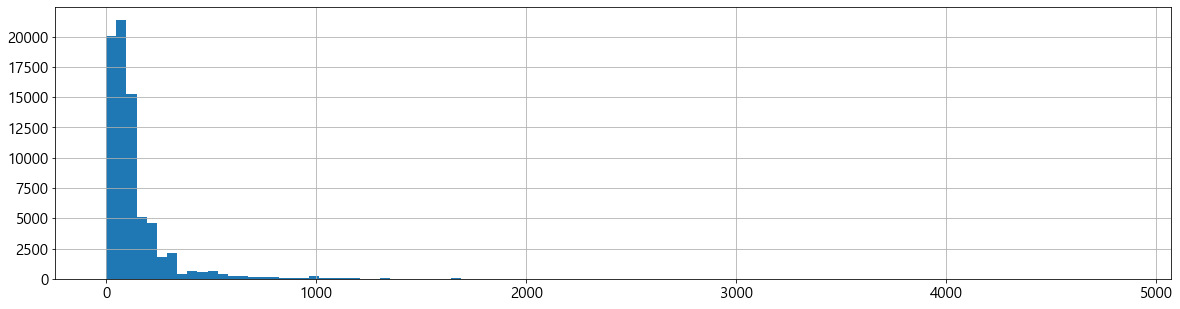

In [37]:
# 히스토그램 생성: 대다수가 1000달러 이하임을 확인 (거기다가 굉장히 치우침을 확인)
Train_df['TransactionAmt'].hist(bins = 100)

In [38]:
# 한쪽에 매우 치우침을 확인함: 거래 금액이 매우 크거나 작은 것 자체가 특징이 되지 않을까?
Train_df['TransactionAmt'].describe()

count    75000.000000
mean       131.143299
std        207.761063
min          0.292000
25%         45.000000
50%         75.000000
75%        136.422000
max       4829.950000
Name: TransactionAmt, dtype: float64

([<matplotlib.axis.XTick at 0x292d5ff30a0>,
 [Text(1, 0, 'Fraud'), Text(2, 0, 'not Fraud')])

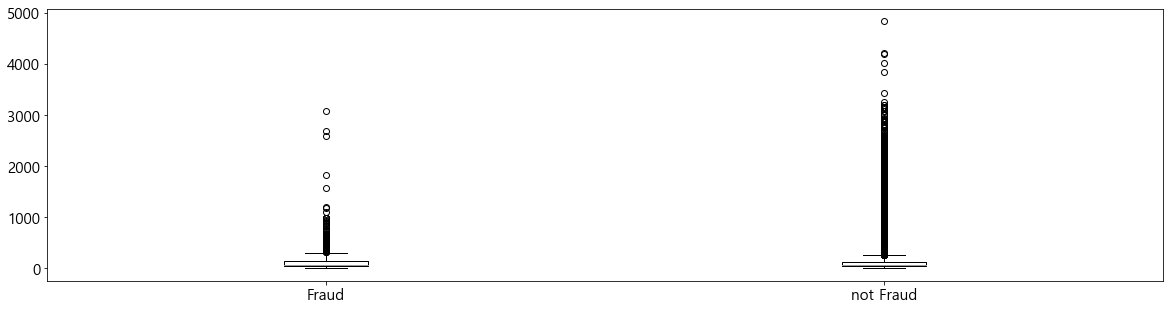

In [39]:
TransactionAmt_Fraud = Train_df['TransactionAmt'].loc[Train_df['isFraud'] == 1]
TransactionAmt_not_Fraud = Train_df['TransactionAmt'].loc[Train_df['isFraud'] == 0]

# 대부분 이상치로 판단되어 정상적인 해석이 쉽지 않음 (다만, Fraud인 경우의 범위가 더 좁음)
plt.boxplot([TransactionAmt_Fraud, TransactionAmt_not_Fraud])
plt.xticks([1, 2], ['Fraud', 'not Fraud'])

In [40]:
# 사기 거래의 경우
TransactionAmt_Fraud.describe()

count    1936.000000
mean      131.682030
std       185.335415
min         0.292000
25%        40.656000
50%        77.000000
75%       150.000000
max      3081.970000
Name: TransactionAmt, dtype: float64

In [41]:
# 사기 거래가 아닌 경우
TransactionAmt_not_Fraud.describe()

count    73064.000000
mean       131.129024
std        208.323571
min          1.000000
25%         45.000000
50%         75.000000
75%        134.950000
max       4829.950000
Name: TransactionAmt, dtype: float64

In [42]:
# 특별한 관계를 찾기는 어려움: 또한, 사기 거래인 경우에는 데이터가 많아서 범위가 커보일 수 있음 
# 따라서 라벨과 관계를 고려하지 않고, 치우침만 해결하기로 결정

2.5.2 C 관련 변수 (C3 제외)

In [43]:
# 변수 목록 생성
C_columns = ['C' + str(i) for i in range(1, 15) if i != 3]
C_columns

['C1',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14']

In [44]:
# 대다수의 변수가 75%값은 10미만인데, max값은 매우 큼 ==> 이상하다?
Train_df[C_columns].describe()

,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000
mean,40.813373,47.528107,19.086853,4.178747,23.097840,15.617760,25.871013,3.292467,26.422867,29.550893,21.874093,45.322733,16.963907
std,311.047917,362.923237,157.815155,21.579559,158.594517,150.583589,230.399438,14.071541,231.078850,217.623784,211.339116,220.311795,103.713498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000
75%,2.000000,2.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,9.000000,2.000000
max,4685.000000,5691.000000,2253.000000,295.000000,2253.000000,2255.000000,3331.000000,194.000000,3257.000000,3188.000000,3188.000000,2918.000000,1429.000000


In [45]:
# 상위 90% 값 확인
Train_df[C_columns].quantile(0.90)

C1      6.0
C2      6.0
C4      1.0
C5      2.0
C6      4.0
C7      1.0
C8      1.0
C9      3.0
C10     1.0
C11     4.0
C12     1.0
C13    34.0
C14     5.0
Name: 0.9, dtype: float64

In [46]:
# 상위 95%값 확인
Train_df[C_columns].quantile(0.95)

C1      48.05
C2      53.00
C4       2.00
C5       5.00
C6      29.00
C7       1.00
C8       2.00
C9       6.00
C10      2.00
C11     32.00
C12      1.00
C13    158.00
C14     27.00
Name: 0.95, dtype: float64

In [47]:
# 상위 99%값 확인
Train_df[C_columns].quantile(0.99)

C1     1180.01
C2     1482.00
C4      815.00
C5      136.00
C6      823.01
C7      622.01
C8      899.01
C9       82.00
C10    1028.01
C11     923.01
C12     852.01
C13     883.00
C14     568.00
Name: 0.99, dtype: float64

In [48]:
# C 관련 변수는 모두 치우침이 매우 심각함
# 상위 95%값과 99% 값의 차이가 너무 많이 남
# 변수로 활용하기 어려워보임 ==> 이진화를 하기에는 자르는 구간 설정이 어려움 ==> 해당 특징을 사용하려면 트리 계열 모델 사용이 필수적

card1, 2, 3, 5

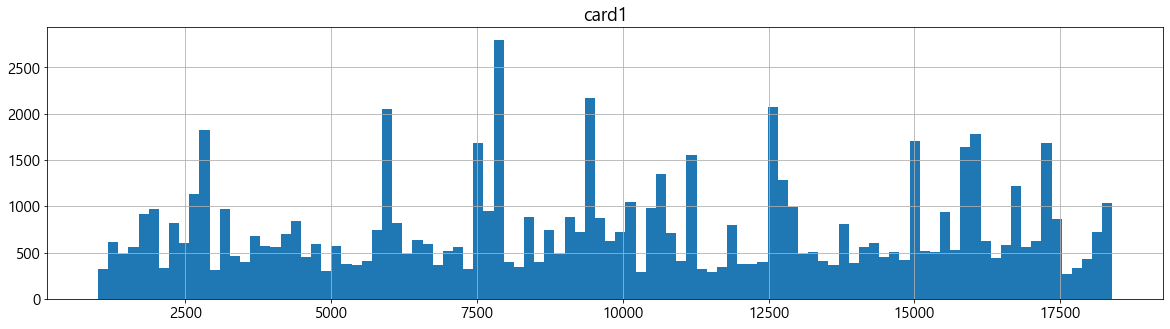

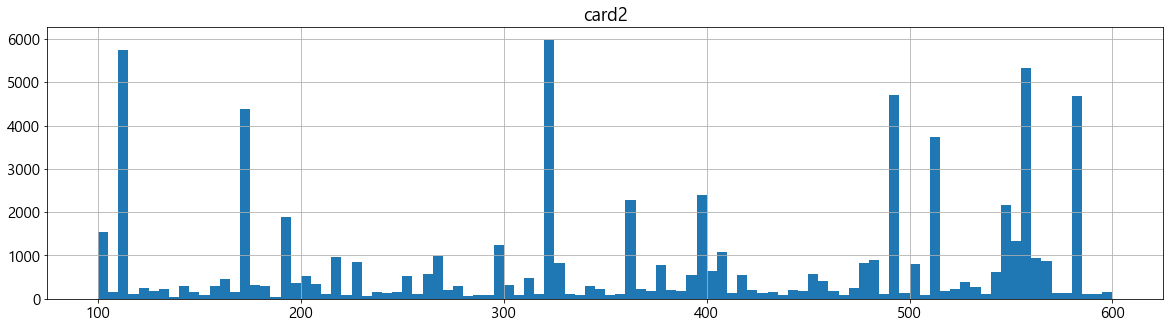

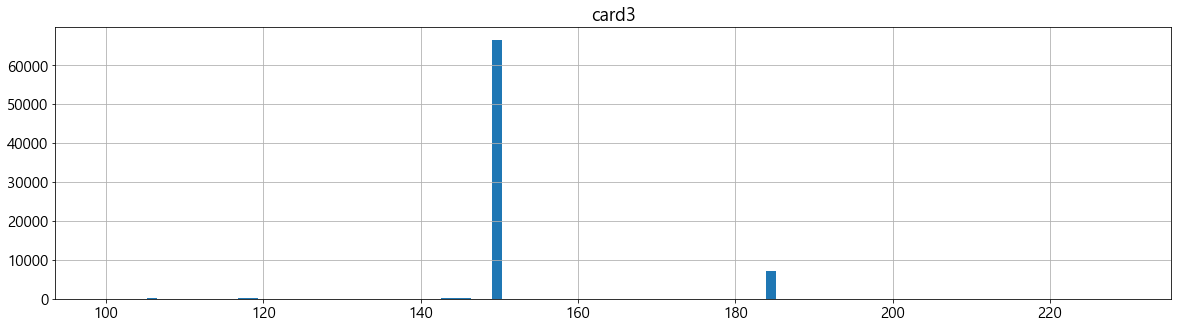

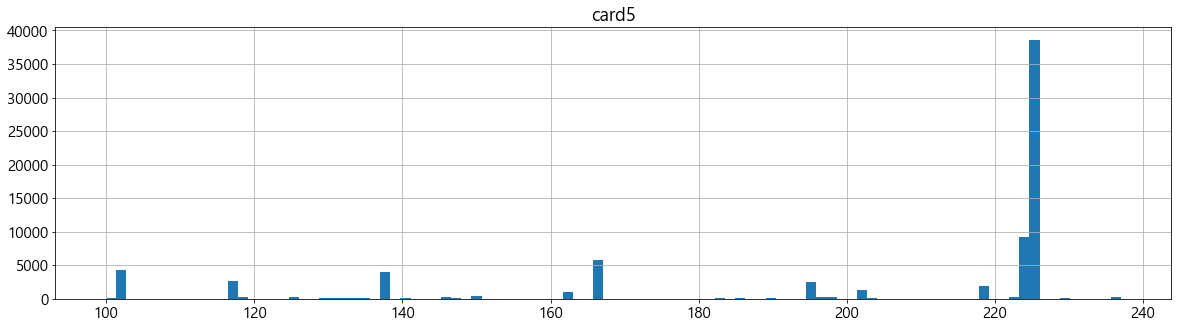

In [49]:
# 히스토그램 확인: card3과 card5의 분포가 특이함 (치우침이 특정 방향으로 일어나지는 않았음. 사실상 범주 변수로 보는 것이 바람직)
# 연속형 변수로 간주할 수 있는 card1과 card3은 결측 처리 필요
card_columns = ['card1', 'card2', 'card3', 'card5']
for col in card_columns:
    plt.title(col)
    Train_df[col].hist(bins = 100)
    plt.show()

In [50]:
# 값의 분포 확인
Train_df[card_columns].describe()

,card1,card2,card3,card5
count,75000.000000,73965.000000,74998.000000,74620.000000
mean,9884.216107,370.329061,153.219273,200.155602
std,4931.854603,159.545315,11.143767,40.863172
min,1001.000000,100.000000,100.000000,100.000000
25%,6019.000000,215.000000,150.000000,166.000000
50%,9678.000000,385.000000,150.000000,226.000000
75%,14280.000000,514.000000,150.000000,226.000000
max,18395.000000,600.000000,229.000000,237.000000


In [51]:
Train_df['card3'].value_counts() # 150인지, 185인지 아닌지를 나타내는 변수로 변환 필요

150.0    66531
185.0     7202
144.0      207
106.0      134
146.0      123
         ...  
208.0        1
206.0        1
120.0        1
180.0        1
186.0        1
Name: card3, Length: 70, dtype: int64

In [52]:
Train_df['card3_150'] = (Train_df['card3'] == 150).astype(int)
Train_df['card3_185'] = (Train_df['card3'] == 185).astype(int)

In [53]:
Train_df.groupby('card3_150')['isFraud'].mean() # 차이가 있음을 확인

card3_150
0    0.087377
1    0.017977
Name: isFraud, dtype: float64

In [54]:
Train_df.groupby('card3_185')['isFraud'].mean() # 차이가 있음을 확인

card3_185
0    0.017906
1    0.100250
Name: isFraud, dtype: float64

In [55]:
Train_df['card5'].value_counts() # 226인지 아닌지를 나타내는 변수로 변환 필요

226.0    38589
224.0     9150
166.0     5719
102.0     4301
117.0     2674
         ...  
210.0        1
140.0        1
200.0        1
120.0        1
113.0        1
Name: card5, Length: 83, dtype: int64

In [56]:
Train_df['card5_226'] = (Train_df['card5'] == 226).astype(int)

In [57]:
Train_df.groupby('card5_226')['isFraud'].mean() # 차이가 있음을 확인

card5_226
0    0.030815
1    0.021094
Name: isFraud, dtype: float64

## 3. 데이터 전처리

#### 3.1 이진화

- 특정 값을 갖는 변수로 변환하면, 결측값은 자동으로 0을 갖게 되므로 결측 처리를 생략할 수 있음
- card4 이진화 : american express라는 값을 갖는지 여부를 나타내는 특징으로 변환
- card6 이진화 : creidt 이라는 값을 갖는지 여부를 나타내는 특징으로 변환
- NA_R_emaildomain 변수 생성 : R_emaildomain 변수가 결측인지를 나타내는 특징 생성
- same_email 변수 생성 : R_emaildomain 과 P_emaildomain 이 같은지를 나타내는 특징 생성
- C3_over_1 변수 생성 : C3  값이 1보다 크거나 같은지를 나타내는 변수 생성

card4 이진화

In [58]:
Train_X['american_express'] = (Train_X.loc[:, 'card4'] == 'american express').astype(int)
Train_X.drop('card4', axis = 1, inplace = True)

In [59]:
Test_X['american_express'] = (Test_X.loc[:, 'card4'] == 'american express').astype(int)
Test_X.drop('card4', axis = 1, inplace = True)

card6 이진화

In [60]:
Train_X['credit'] = (Train_X.loc[:, 'card6'] == 'credit').astype(int)
Train_X.drop('card6', axis = 1, inplace = True)

In [61]:
Test_X['credit'] = (Test_X.loc[:, 'card6'] == 'credit').astype(int)
Test_X.drop('card6', axis = 1, inplace = True)

same_email 변수 추가 및 기존 변수 삭제

In [62]:
Train_X['NA_R_emaildomain'] = (Train_X['R_emaildomain'].isnull()).astype(int)
Train_X['same_emaildomain'] = (Train_X['P_emaildomain'] == Train_X['R_emaildomain']).astype(int)
Train_X.drop(['P_emaildomain', 'R_emaildomain'], axis = 1, inplace = True)

In [63]:
Test_X['NA_R_emaildomain'] = (Test_X['R_emaildomain'].isnull()).astype(int)
Test_X['same_emaildomain'] = (Test_X['P_emaildomain'] == Test_X['R_emaildomain']).astype(int)
Test_X.drop(['P_emaildomain', 'R_emaildomain'], axis = 1, inplace = True)

C3_over_1 변수 생성

In [64]:
Train_X['C3_over_1'] = (Train_X['C3'] >= 1).astype(int)
Train_X.drop(['C3'], axis = 1, inplace = True)

In [65]:
Test_X['C3_over_1'] = (Test_X['C3'] >= 1).astype(int)
Test_X.drop(['C3'], axis = 1, inplace = True)

#### 3.2 결측 대체 및 더미화 수행

- 더미화를 수행하기 위해, M1 - M9 변수에 발생한 결측 값을 문자로 치환
- ProductCD 변수와 M1 - M9 변수에 대한 더미화 수행

In [89]:
#!pip install category_encoders

In [67]:
from category_encoders import OneHotEncoder as OHE

Train_X[M_columns] = Train_X[M_columns].fillna("결측")
dummy_model = OHE(cols = M_columns + ['ProductCD'], drop_invariant = True).fit(Train_X)
Train_X = dummy_model.transform(Train_X)

Train_X

'''
encoder = OneHotEncoder(use_cat_names=True, cols="Tier")

df_encoded = encoder.fit_transform(df)

df_encoded.head(6)
'''

'\nencoder = OneHotEncoder(use_cat_names=True, cols="Tier")\n\ndf_encoded = encoder.fit_transform(df)\n\ndf_encoded.head(6)\n'

In [68]:
Train_X.head()

,TransactionAmt,ProductCD_1,ProductCD_2,ProductCD_3,ProductCD_4,ProductCD_5,card1,card2,card3,card5,...,M8_2,M8_3,M9_1,M9_2,M9_3,american_express,credit,NA_R_emaildomain,same_emaildomain,C3_over_1
3829,190.00,1,0,0,0,0,9500,321.0,150.0,226.0,...,0,0,1,0,0,0,0,1,0,0
21977,32.97,1,0,0,0,0,10057,225.0,150.0,224.0,...,0,0,1,0,0,0,0,1,0,0
88588,117.00,1,0,0,0,0,7207,111.0,150.0,226.0,...,0,0,1,0,0,0,0,1,0,0
69489,125.00,0,1,0,0,0,2772,512.0,150.0,226.0,...,0,0,1,0,0,0,0,0,1,0
65218,100.00,0,0,1,0,0,13220,562.0,150.0,197.0,...,0,0,1,0,0,0,1,1,0,0


In [69]:
Test_X[M_columns] = Test_X[M_columns].fillna("결측")
Test_X = dummy_model.transform(Test_X)

In [70]:
Test_X.head()

,TransactionAmt,ProductCD_1,ProductCD_2,ProductCD_3,ProductCD_4,ProductCD_5,card1,card2,card3,card5,...,M8_2,M8_3,M9_1,M9_2,M9_3,american_express,credit,NA_R_emaildomain,same_emaildomain,C3_over_1
10967,30.00,1,0,0,0,0,13307,428.0,150.0,166.0,...,0,0,1,0,0,0,0,1,0,0
58031,247.95,1,0,0,0,0,12501,490.0,150.0,226.0,...,0,0,1,0,0,0,0,1,0,0
56399,150.00,0,1,0,0,0,2944,399.0,150.0,236.0,...,0,0,1,0,0,1,1,0,1,0
71320,100.00,0,1,0,0,0,6019,583.0,150.0,226.0,...,0,0,1,0,0,0,1,0,1,0
23876,100.00,0,0,1,0,0,1078,512.0,150.0,226.0,...,0,0,1,0,0,0,0,0,1,0


#### 3.3 치우침 해소

- 로그 변환을 통해, TransactionAmt에 있는 변수 치우침 해결

In [71]:
Train_X['TransactionAmt'] = np.log(Train_X['TransactionAmt'])

In [72]:
Test_X['TransactionAmt'] = np.log(Test_X['TransactionAmt'])

#### 3.4 연속형 변수를 이진화

- card3 이라는 변수가 150인지, 185인지를 나타내는 변수 생성
- card5 라는 변수가 226인지를 나타내는 변수 생성

In [73]:
Train_X['card3_150'] = (Train_X['card3'] == 150).astype(int)
Train_X['card3_185'] = (Train_X['card3'] == 185).astype(int)
Train_X['card5_226'] = (Train_X['card5'] == 226).astype(int)

Train_X.drop(['card3', 'card5'], axis = 1, inplace = True)

In [74]:
Test_X['card3_150'] = (Test_X['card3'] == 150).astype(int)
Test_X['card3_185'] = (Test_X['card3'] == 185).astype(int)
Test_X['card5_226'] = (Test_X['card5'] == 226).astype(int)

Test_X.drop(['card3', 'card5'], axis = 1, inplace = True)

#### 3.5 결측 대체 (주의: 특정 값을 기준으로 이진화하려면 결측 대체가 마지막에 나와야 함!)
- 이진화가 되지 않은 특징에 대한 결측치를 처리하기 위해 Imputer를 사용

In [75]:
from sklearn.impute import SimpleImputer as SI
imputer = SI().fit(Train_X)
Train_X = pd.DataFrame(imputer.transform(Train_X), columns = Train_X.columns)
Test_X = pd.DataFrame(imputer.transform(Test_X), columns = Train_X.columns)

#### 3.6 클래스 불균형 문제
- 사기 거래 수가 정상 거래에 비해 매우 적으므로, 클래스 불균형 문제가 존재할 가능성이 매우 큼
- 이를 방지하기 위해, 언더샘플링과 비용민감모델을 고려 ( 오버샘플링을 하기에는 샘플이 너무 많음)


In [76]:
# 현재 클래스 간 빈도차이가 매우 심각함을 확인 (97: 3 정도의 비율)
# 전체 샘플 수가 10만개이므로, 오버샘플링을 수행하기에는 부적절
# 언더샘플링을 수행하게 되면 남는 샘플이 약 4천개이며, 특징 수가 그리 많지 않음 ==> 언더샘플링 혹은 비용 민감 모델 고려 필요

### 4. 모델 학습
- 사용 모델: Tree 기반의 앙상블 (Random Forest, XGBoost) 
- 언더샘플링과 비용민감모델 동시 고려

모델 파라미터 그리드 설계

In [90]:
#!pip install imblearn

In [78]:
import copy
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import *
from sklearn.ensemble import RandomForestClassifier as RFC
from xgboost import XGBClassifier as XGB
from imblearn.under_sampling import NearMiss

# 언더샘플링이 적용된 데이터에 사용할 그리드 생성 (복사를 위해, ParameterGrid를 일단 적용하지 않음)
RF_grid = dict({"n_estimators":[100, 200],
               "max_depth":[3, 4, 5, 6]})

XGB_grid = dict({"n_estimators":[100, 200],
               "max_depth":[3, 4, 5, 6],
                "learning_rate":[0.05, 0.1, 0.2]})

# 언더샘플링이 적용되지 않은 데이터에 사용할 그리드 생성
class_imbalance_ratio = sum(Train_Y == 0) / sum(Train_Y == 1)
RF_cs_grid = copy.copy(RF_grid)
RF_cs_grid['class_weight'] = [{1:class_imbalance_ratio * w, 0:1} for w in [1, 0.9, 0.7, 0.5]]

XGB_cs_grid = copy.copy(XGB_grid)
XGB_cs_grid['class_weight'] = [{1:class_imbalance_ratio * w, 0:1} for w in [1, 0.9, 0.7, 0.5]]

RF_grid = ParameterGrid(RF_grid)
RF_cs_grid = ParameterGrid(RF_cs_grid)
XGB_grid = ParameterGrid(XGB_grid)
XGB_cs_grid = ParameterGrid(XGB_cs_grid)

In [79]:
# 최종 그리드 생성 및 모델 테스트 함수 생성
grid_for_cs_model = {RFC:RF_cs_grid, XGB:XGB_cs_grid}
grid_for_not_cs_model = {RFC:RF_grid, XGB:XGB_grid}

from sklearn.metrics import f1_score
def model_test(model, test_x, test_y):
    pred_Y = model.predict(test_x)
    return f1_score(test_y, pred_Y)

파라미터 튜닝 

In [80]:
# 비용 민감 모델 테스트
# 최고값 초기화

best_score = -1
max_iter = 0
for k in range(34, 4, -5): 
    for model_func in grid_for_cs_model:
        for parameter in grid_for_cs_model[model_func]:            
            max_iter += 1

# 데이터 꼬임을 방지하기 위해 데이터 복제
T_X = Train_X.copy() 
t_X = Test_X.copy()

num_iter = 1
for k in range(34, 4, -5): 
    selector = SelectKBest(mutual_info_classif, k = k).fit(T_X, Train_Y)
    selected_columns = T_X.columns[selector.get_support()]
    T_X = T_X[selected_columns]
    t_X = t_X[selected_columns]
    for model_func in grid_for_cs_model:
        for parameter in grid_for_cs_model[model_func]:            
            model = model_func(**parameter).fit(T_X, Train_Y)
            score = model_test(model, t_X, Test_Y)
            if score > best_score:
                best_model = model
                best_features = selected_columns
                best_score = score            
                                
            print(num_iter, "/", max_iter, best_score)
            num_iter += 1            

1 / 768 0.17089452603471295
2 / 768 0.18172983479105928
3 / 768 0.18172983479105928
4 / 768 0.18172983479105928
5 / 768 0.18172983479105928
6 / 768 0.18172983479105928
7 / 768 0.19301848049281314
8 / 768 0.19528619528619529
9 / 768 0.21978021978021978
10 / 768 0.22628726287262874
11 / 768 0.22628726287262874
12 / 768 0.22628726287262874
13 / 768 0.22628726287262874
14 / 768 0.22628726287262874
15 / 768 0.22628726287262874
16 / 768 0.22628726287262874
17 / 768 0.23888404533565824
18 / 768 0.23888404533565824
19 / 768 0.2645133129637713
20 / 768 0.2645133129637713
21 / 768 0.28443722064201543
22 / 768 0.28443722064201543
23 / 768 0.30165790537808335
24 / 768 0.30704344158582875
25 / 768 0.30704344158582875
26 / 768 0.30704344158582875
27 / 768 0.30704344158582875
28 / 768 0.30704344158582875
29 / 768 0.3231197771587744
30 / 768 0.3283249860879243
31 / 768 0.3557358053302433
32 / 768 0.3557919621749409
[13:47:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/le

In [87]:
# NM_model_test = NearMiss(version = 2, sampling_strategy = {1:Train_Y.value_counts().iloc[-1], 0:int(Train_Y.value_counts().iloc[-1] * w * class_imbalance_ratio)}) 

In [ ]:
# NM_model_test.fit()
# NM_model_test.fit_resample()

In [88]:
# 최고값은 초기화하지 않음 (이전에 업데이트해뒀으므로)


max_iter = 0
for w in [1, 0.9, 0.7, 0.5]:
    for k in range(34, 4, -5): 
        for model_func in grid_for_not_cs_model:
            for parameter in grid_for_not_cs_model[model_func]:            
                max_iter += 1

# 일반 모델 파라미터 튜닝 수행
num_iter = 1
for w in [1, 0.9, 0.7, 0.5]:
    # 데이터 꼬임을 방지하기 위해 데이터 복제
    T_X = Train_X.copy() 
    t_X = Test_X.copy() 
    
    NM_model = NearMiss(version = 2, sampling_strategy = {1:Train_Y.value_counts().iloc[-1],
                                                          0:int(Train_Y.value_counts().iloc[-1] * w * class_imbalance_ratio)})  
        
    u_T_X, u_T_Y = NM_model.fit_resample(T_X, Train_Y)
    u_T_X = pd.DataFrame(u_T_X, columns = T_X.columns)
    
    for k in range(34, 4, -5): 
        selector = SelectKBest(mutual_info_classif, k = k).fit(u_T_X, u_T_Y)
        selected_columns = u_T_X.columns[selector.get_support()]
        u_T_X = u_T_X[selected_columns]
        t_X = t_X[selected_columns]
        for model_func in grid_for_not_cs_model:
            for parameter in grid_for_not_cs_model[model_func]:
                model = model_func(**parameter).fit(u_T_X, u_T_Y)
                score = model_test(model, t_X, Test_Y)
                if score > best_score:
                    best_model = model
                    best_features = selected_columns
                    best_score = score       
                    
                print(num_iter, "/", max_iter, best_score) 
                num_iter += 1

1 / 768 0.6314677930306231
2 / 768 0.6314677930306231
3 / 768 0.6314677930306231
4 / 768 0.6314677930306231
5 / 768 0.6314677930306231
6 / 768 0.6314677930306231
7 / 768 0.6314677930306231
8 / 768 0.6314677930306231
[14:46:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
9 / 768 0.6314677930306231
[14:46:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
10 / 768 0.6314677930306231
[14:46:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Startin

### 모델 적용

In [91]:
model = best_model
features = best_features

In [92]:
test_df = pd.read_csv("sampled_test_transaction.csv")

In [93]:
def pipeline(input_data, dummy_model, imputer, features, model):
    input_data_copy = input_data.copy()
    input_data_copy.drop(['TransactionID', 'TransactionDT'], axis = 1, inplace = True)
    
    # 범주형 변수: 이진화 및 파생 변수 생성
    input_data_copy['american_express'] = (input_data_copy.loc[:, 'card4'] == 'american express').astype(int)
    input_data_copy.drop('card4', axis = 1, inplace = True)

    input_data_copy['credit'] = (input_data_copy.loc[:, 'card6'] == 'credit').astype(int)
    input_data_copy.drop('card6', axis = 1, inplace = True)    
        
    input_data_copy['NA_R_emaildomain'] = (input_data_copy['R_emaildomain'].isnull()).astype(int)
    input_data_copy['same_emaildomain'] = (input_data_copy['P_emaildomain'] == input_data_copy['R_emaildomain']).astype(int)
    input_data_copy.drop(['P_emaildomain', 'R_emaildomain'], axis = 1, inplace = True)    
    input_data_copy['C3_over_1'] = (input_data_copy['C3'] >= 1).astype(int)
    input_data_copy.drop(['C3'], axis = 1, inplace = True)
    
    M_columns = ['M' + str(i) for i in range(1, 10)]    
    input_data_copy[M_columns] = input_data_copy[M_columns].fillna("결측")
    input_data_copy = dummy_model.transform(input_data_copy)  
    
    # 연속형 변수 처리
    input_data_copy['TransactionAmt'] = np.log(input_data_copy['TransactionAmt'])    
    
    input_data_copy['card3_150'] = (input_data_copy['card3'] == 150).astype(int)
    input_data_copy['card3_185'] = (input_data_copy['card3'] == 185).astype(int)
    input_data_copy['card5_226'] = (input_data_copy['card5'] == 226).astype(int) 
    input_data_copy.drop(['card3', 'card5'], axis = 1, inplace = True)
    
    input_data_copy = pd.DataFrame(imputer.transform(Train_X), columns = input_data_copy.columns)
    input_data_copy = input_data_copy[features]
    
    return model.predict(input_data_copy)

In [94]:
pipeline(test_df, dummy_model, imputer, features, model)

ValueError: Unexpected input dimension 391, expected 33